# RL and Advanced DL: Домашнее задание 2

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.  

<img src="tictactoe.png" width="600">
<!-- ![title](tictactoe.png) -->

In [1]:
import numpy as np
from tqdm import tqdm
from tictactoe_env import TicTacToe
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import copy

## Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.
**Disclaimer:** начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [2]:
EMPTY_CODE, X_CODE, O_CODE = '102'
def get_free_spaces(state):
    return np.array([i for i, x in enumerate(state) if x == EMPTY_CODE]).astype(int)
def get_busy_spaces(state):
    return np.array([i for i, x in enumerate(state) if x != EMPTY_CODE]).astype(int)
print(get_free_spaces('111000222'), get_busy_spaces('111000222'))

[0 1 2] [3 4 5 6 7 8]


In [3]:
def update_q(agent, s, a, r, alpha, gamma):
    Q, s_, a_ = agent
    Q[s_][a_] += alpha * (r + gamma * np.max(Q[s] - Q[s_][a_]))
    return Q, s, a

In [4]:
def play(env, Q_x, Q_o, x_random=True, o_random=True):
    env.reset()
    state_, empty_spaces, cur_turn = env.getState()
    done = False
    agents = [Q_x, Q_o]
    turn = 0
    while not done:
        q = agents[turn]
        if (turn == 0 and x_random) or (turn == 1 and o_random):
            action_ = random.choice(get_free_spaces(state_))
        else:
            action_ = np.argmax(q[state_])
        (state_, empty_spaces, cur_turn), reward_, done, _ = env.step(env.action_from_int(action_))
        turn = 1 - turn
    if reward_ == 1: # x wins
        return (1, 0)
    elif reward_ == -1: # o wins
        return (0, 1)
    else:
        return (0, 0)
        

In [5]:
ROWS, COLS, WIN = 3, 3, 3

In [6]:
def q_learning(rows=ROWS, cols=COLS, win=WIN,
              Q_x=None, Q_o=None,
              num_episodes=50000,
              epsilon=0.7,
              alpha=5e-2,
              gamma=1.0,
              eval_each=1000,
              eval_num_games=100,
              separate_tables=False):
    if Q_x is None:
        Q_x = defaultdict(lambda: np.zeros(cols * rows))
    if Q_o is None:
        Q_o = defaultdict(lambda: np.zeros(cols * rows))
    env = TicTacToe(rows, cols, win)
    
    eval_data = {'x': [], 'o': []}

    for i in tqdm(range(num_episodes)):
        env.reset()
        state_, empty_spaces, cur_turn = env.getState()
        s_x, s_o, a_x, a_o = None, None, None, None
        if separate_tables:
            agents = [(Q_x, s_x, a_x), (Q_o, s_o, a_o)]
        else:
            agents = [(Q_x, s_x, a_x), (Q_x, s_o, a_o)]
        done = False
        turn = 0
        reward_ = 0
        while not done:
            agent = agents[turn]
            q, s_, a_ = agent
            q[state_][get_busy_spaces(state_)] = -1e10
            if random.random() > epsilon:
                action_ = np.argmax(q[state_])
            else:
                action_ = random.choice(get_free_spaces(state_))
            agent = update_q(agent, state_, action_, reward_, alpha, gamma)
            (state_, empty_spaces, cur_turn), reward_, done, _ = env.step(env.action_from_int(action_))
            agents[turn] = agent
            turn = 1 - turn
        # last action
        if reward_ == -10: # draw
            agents[1 - turn] = update_q(agent, state_, action_, reward_, alpha, gamma)
        else:
            agents[0] = update_q(agents[0], state_, action_, reward_, alpha, gamma)
            agents[1] = update_q(agents[1], state_, action_, -reward_, alpha, gamma)

        # evaluate
        if not separate_tables:
            Q_o = Q_x
        if i % eval_each == 0:
            x_rewards, o_rewards = [], []
            for j in range(eval_num_games):
                
                # play consciously for x
                x_r, o_r = play(env, Q_x, Q_o, x_random=False, o_random=True)
                x_rewards.append(x_r)

                # play consciously for o
                x_r, o_r = play(env, Q_x, Q_o, x_random=True, o_random=False)
                o_rewards.append(o_r)
                
            eval_data['x'].append(np.mean(x_rewards))
            eval_data['o'].append(np.mean(o_rewards))
    return Q_x, Q_o, eval_data

### Доска 3x3

In [7]:
num_episodes = 50000
eval_each = 500
eval_num_games = 500
Q_x, Q_o, eval_data = q_learning(rows=3, cols=3, win=3,
                                 num_episodes=num_episodes,
                                 epsilon=0.3,
                                 alpha=5e-2,
                                 eval_each=eval_each,
                                 eval_num_games=eval_num_games)

# Q_x, Q_o = dict(Q_x), dict(Q_o)
print(len(Q_x.keys()), len(Q_o.keys()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:58<00:00, 854.43it/s]

4471 4471


In [8]:
def plot_eval_data(eval_data, num_episodes, eval_each):
#     scale = num_episodes // eval_each

    fig, axs = plt.subplots(1, len(eval_data), figsize=(12, 8))
    for i, key in enumerate(eval_data):
        axs[i].plot(range(0, len(eval_data[key]) * eval_each, eval_each), eval_data[key])
        axs[i].set_title(key)

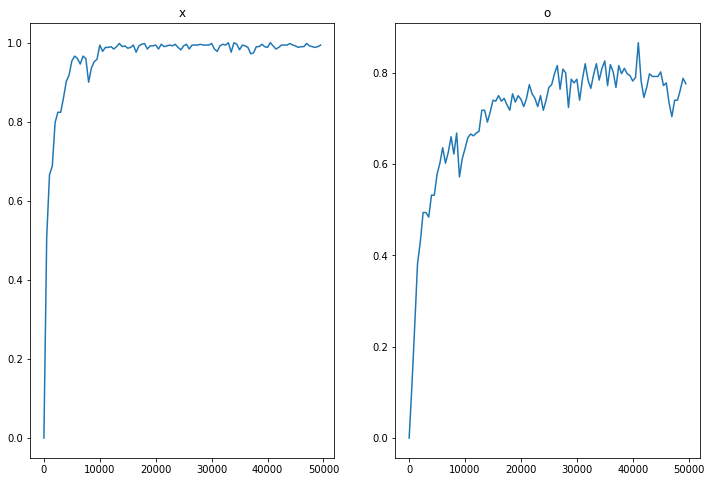

In [9]:
plot_eval_data(eval_data=eval_data, num_episodes=num_episodes, eval_each=eval_each)

Выглядит как и ожидалось. Рост выигрыша при росте опыта. Крестиками играть в среднем выгоднее чем ноликами

### Доска 4x4

In [10]:
# 3-items win
num_episodes = 50000
eval_each = 500
eval_num_games = 500
Q_x, Q_o, eval_data = q_learning(rows=4, cols=4, win=3,
                                 Q_x=None, Q_o=None,
                                 num_episodes=num_episodes,
                                 epsilon=0.3,
                                 alpha=5e-2,
                                 eval_each=eval_each,
                                 eval_num_games=eval_num_games)

print(len(Q_x.keys()), len(Q_o.keys()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [-315:17:50<00:00, -0.04it/s]

103291 103291


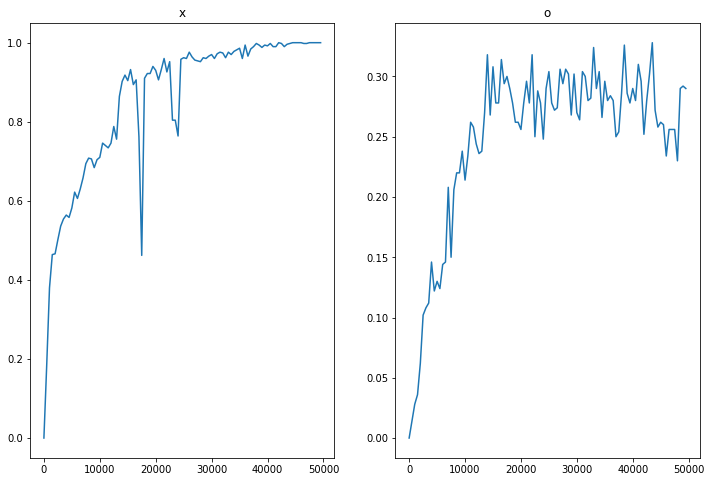

In [11]:
plot_eval_data(eval_data=eval_data, num_episodes=num_episodes, eval_each=eval_each)

Для ноликов подозрительно низкий выигрыш. Возможно много ничьих конкретно при такой ситуации (когда цель собрать 3 в ряд) ???

In [12]:
# the same with 4-items win
num_episodes = 300000
eval_each = 3000
eval_num_games = 500
Q_x, Q_o, eval_data = q_learning(rows=4, cols=4, win=4,
                                 Q_x=None, Q_o=None,
                                 num_episodes=num_episodes,
                                 epsilon=0.3,
                                 alpha=5e-2,
                                 eval_each=eval_each,
                                 eval_num_games=eval_num_games)

print(len(Q_x.keys()), len(Q_o.keys()))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [07:00<00:00, 714.12it/s]

424964 424964


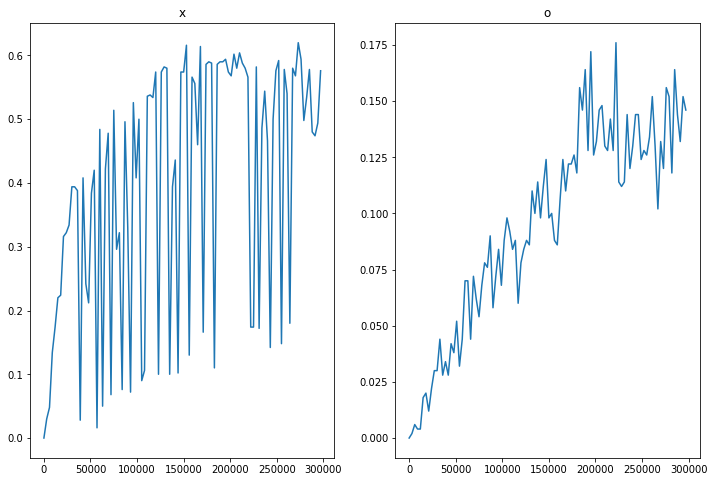

In [13]:
plot_eval_data(eval_data=eval_data, num_episodes=num_episodes, eval_each=eval_each)

Наблюдается рост выигрыша с ростом опыта и для крестиков (быстрее) и для ноликов (медленнее)

### Доска 5x5

In [14]:
# 3-items win
num_episodes = 50000
eval_each = 500
eval_num_games = 500
Q_x, Q_o, eval_data = q_learning(rows=5, cols=5, win=3,
                                 Q_x=None, Q_o=None,
                                 num_episodes=num_episodes,
                                 epsilon=0.3,
                                 alpha=5e-2,
                                 eval_each=eval_each,
                                 eval_num_games=eval_num_games)

print(len(Q_x.keys()), len(Q_o.keys()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:46<00:00, 469.07it/s]

196473 196473


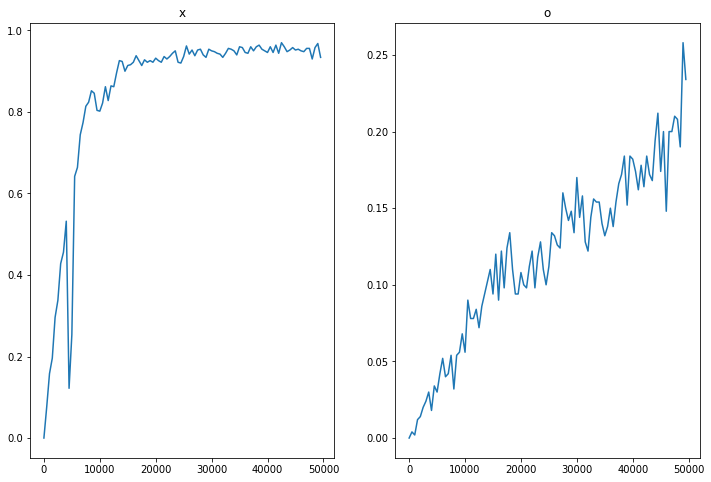

In [15]:
plot_eval_data(eval_data=eval_data, num_episodes=num_episodes, eval_each=eval_each)

In [16]:
# the same but with 5-items win
num_episodes = 500000
eval_each = 5000
eval_num_games = 500
Q_x, Q_o, eval_data = q_learning(rows=5, cols=5, win=5,
                                 Q_x=None, Q_o=None,
                                 num_episodes=num_episodes,
                                 epsilon=0.3,
                                 alpha=5e-2,
                                 eval_each=eval_each,
                                 eval_num_games=eval_num_games)

print(len(Q_x.keys()), len(Q_o.keys()))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [21:11<00:00, 393.34it/s]

5740224 5740224


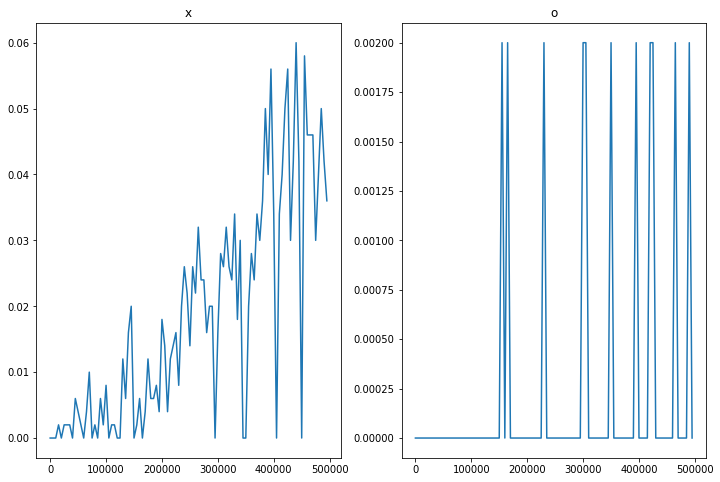

In [17]:
plot_eval_data(eval_data=eval_data, num_episodes=num_episodes, eval_each=eval_each)

## Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).  
$\;\;\;\;$3\. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.  
$\;\;\;\;$4\. Реализуйте Double DQN и/или Dueling DQN.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [19]:
from pdb import set_trace

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

cuda


In [21]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def put(self, v):
        if len(self.memory) < self.capacity:
            self.memory.append(v)
        self.position += 1
        self.position %= self.capacity
        
    def get_random(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [22]:
class DQN(nn.Module):
    def __init__(self, conv_out_size=256, hidden_size=256, n_cols=3, n_rows=3):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=conv_out_size, kernel_size=(3, 3))
        
        conv_out_size *= (n_cols - 2)
        conv_out_size *= (n_rows - 2) # to deal with 4x4 and larger boards
        
        self.fc_1 = nn.Linear(conv_out_size, hidden_size)
        self.fc_2 = nn.Linear(hidden_size, n_cols * n_rows)
        
    def forward(self, X):
        X = F.relu(self.conv_1(X)).flatten(start_dim=1)
        X = F.relu(self.fc_1(X))
        X = self.fc_2(X)
        return X

In [23]:
class DuelingDQN(nn.Module):
    
    def __init__(self, conv_out_size=256, hidden_size=256, n_cols=3, n_rows=3):
        
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=conv_out_size, kernel_size=(3, 3))
    
        conv_out_size *= (n_cols - 2)
        conv_out_size *= (n_rows - 2)
        
        self.V = nn.Sequential(nn.Linear(conv_out_size, hidden_size),
                               nn.ReLU(),
                               nn.Linear(hidden_size, 1))
        
        self.A = nn.Sequential(nn.Linear(conv_out_size, hidden_size),
                               nn.ReLU(),
                               nn.Linear(hidden_size, 9))
        
    def forward(self, X):
        X = F.relu(self.conv_1(X)).squeeze(-1).squeeze(-1)
        A = self.A(X)
        V = self.V(X)
        Q = V + (A - A.mean(dim=1, keepdim=True).expand(X.size(0), 9))
        
        return Q

In [24]:
LR = 1e-6
W_DECAY = 1e-9
CONV_OUT_SIZE = 128
HIDDEN_SIZE = 512
LOSS = F.l1_loss
MODEL_NAME = 'DQN'

def create_model(cols, rows,
                 model_name=MODEL_NAME,
                 lr=LR,
                 w_decay=W_DECAY,
                 conv_out_size=CONV_OUT_SIZE,
                 hidden_size=HIDDEN_SIZE):
    if model_name == 'DQN':
        model = DQN(conv_out_size=conv_out_size, hidden_size=hidden_size, n_cols=cols, n_rows=rows)
    elif model_name == 'DuelingDQN':
        model = DuelingDQN(conv_out_size=conv_out_size, hidden_size=hidden_size, n_cols=cols, n_rows=rows)
    else:
        raise NotImplementedError
    
    opt = optim.Adam(model.parameters())
    return model.to(device), opt

In [25]:
def train_batch(model, model_t, optimizer, criterion, replay_memory, batch_size=128, gamma=1.0):
    if len(replay_memory) < batch_size:
        return
    states, next_states, actions, rewards = list(zip(*replay_memory.get_random(batch_size)))
#     set_trace()
    states = torch.FloatTensor(states).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    
    model.train()
    
    Q_pred = model(states).gather(1, actions.view(-1, 1)).flatten()
    Q_max = model(next_states).detach().max(dim=1)[0]
    Q_next = rewards + gamma * Q_max
    
    loss = criterion(Q_pred, Q_next)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [26]:
def play(env, model_x, model_o, x_random=True, o_random=True):
    model_x.eval()
    model_o.eval()
    env.reset()
    state_hash, empty_spaces, cur_turn = env.getState()
    state_ = env.board
    done = False
    
    models = [model_x, model_o]

    turn = 0
    while not done:
        model = models[turn]
        if (turn == 0 and x_random) or (turn == 1 and o_random):
            action_ = random.choice(get_free_spaces(state_hash))
        else:
            state_ = np.array([state_ == 1, state_ == -1, state_ == 0]).astype(float)
            state_ = torch.FloatTensor([state_]).to(device)
#             action_ = model(state_).detach().max(1)[1][0].item()
            model_output = model(state_)
            values, indices = model_output.sort(1, descending=True)
            for val, action in zip(values[0], indices[0]):
                if action.item() in get_free_spaces(state_hash):
                    break
            action_ = action.item()
        (state_hash, empty_spaces, cur_turn), reward_, done, _ = env.step(env.action_from_int(action_))
        state_ = env.board
        turn = 1 - turn
    if reward_ == 1: # x wins
        return (1, 0)
    elif reward_ == -1: # o wins
        return (0, 1)
    else:
        return (0, 0) # draw

In [27]:
def add_experience(memory, state, action, next_state, next_action, reward):
    next_state = np.array([next_state == 1, next_state == -1, next_state == 0]).astype(float)
    if state is not None:
        memory.put((state, next_state, action, reward))
    return next_state, next_action

In [28]:
def dqn_learning(rows, cols, win,
                 model_name,
                 lr, w_decay,
                 conv_out_size,
                 hidden_size,
                 criterion,
                 num_episodes=20000, epsilon=0.5,
                 batch_size=64, gamma=0.9,
                 target_update=10,
                 mem_capacity=10000,
                 eval_each=500, eval_num_games=500):
#     set_trace()
    env = TicTacToe(rows, cols, win)
    losses_x, losses_o = [], []
    s_x, a_x, s_o, a_o = None, None, None, None
    model_x, opt_x = create_model(rows=rows, cols=cols,
                                  model_name=model_name,
                                  lr=lr,
                                  w_decay=w_decay,
                                  conv_out_size=conv_out_size,
                                  hidden_size=hidden_size)
    model_o, opt_o = create_model(rows=rows, cols=cols,
                                  model_name=model_name,
                                  lr=lr,
                                  w_decay=w_decay,
                                  conv_out_size=conv_out_size,
                                  hidden_size=hidden_size)
    model_x_t = copy.deepcopy(model_x)
    model_o_t = copy.deepcopy(model_o)
    memory_x = ReplayMemory(capacity=mem_capacity)
    memory_o = ReplayMemory(capacity=mem_capacity)
    
    model_x_t.eval()
    model_o_t.eval()
    
    models = [model_x, model_o]
    
    eval_data = {'x': [], 'o': [], 'loss_x': [], 'loss_o': []}]
    \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    

    for i in tqdm(range(num_episodes)):
        env.reset()
        model_x.eval()
        model_o.eval()
        state_hash, empty_spaces, cur_turn = env.getState()
        state_ = env.board.copy()
        done = False
        
        s_x, a_x, s_o, a_o = None, None, None, None
        players = [(s_x, a_x, memory_x), (s_o, a_o, memory_o)]
        turn = 0
        reward_ = 0
        
        # play one episode
        while not done:
            player = players[turn]
            s_, a_, memory_ = player
            reward = 0
            model = models[turn]
            if random.random() > epsilon:
                state_t = np.array([state_ == 1, state_ == -1, state_ == 0]).astype(float)
                state_t = torch.FloatTensor([state_t]).to(device)
                action_ = model(state_t).detach().max(1)[1][0].item()
            else:
                action_ = random.choice(get_free_spaces(state_hash))
            s_, a_ = add_experience(memory=memory_, state=s_, action=a_,
                                    next_state=state_, next_action=action_,
                                    reward=reward_)
            player = s_, a_, memory_
            (state_hash, empty_spaces, cur_turn), reward_, done, _ = env.step(env.action_from_int(action_))
            state_ = env.board.copy()
            players[turn] = player
            turn = 1 - turn
        if reward_ == -10:
            s_, a_ = add_experience(memory=memory_, state=s_, action=a_,
                                    next_state=state_, next_action=action_,
                                    reward=reward_)
        else:
            s_x, a_x, memory_x = players[0]
            _ = add_experience(memory=memory_x, state=s_x, action=a_x,
                               next_state=state_, next_action=action_,
                               reward=reward_)
            s_o, a_o, memory_o = players[1]
            _ = add_experience(memory=memory_o, state=s_o, action=a_o,
                               next_state=state_, next_action=action_,
                               reward=-reward_)
            
        
        # train
        loss_x = train_batch(model=model_x,
                             model_t = model_x_t,
                             optimizer=opt_x,
                             criterion=criterion, 
                             replay_memory=players[0][2],
                             batch_size=batch_size,
                             gamma=gamma)
        if loss_x is not None:
            losses_x.append(loss_x)
            
        loss_o = train_batch(model=model_o,
                             model_t=model_o_t,
                             optimizer=opt_o,
                             criterion=criterion, 
                             replay_memory=players[1][2],
                             batch_size=batch_size,
                             gamma=gamma)
        if loss_o is not None:
            losses_o.append(loss_o)
            
        if i % target_update == 0:
#             model_x_t = copy.deepcopy(model_x)
            model_x_t.load_state_dict(model_x.state_dict())
#             model_o_t = copy.deepcopy(model_o)
            model_o_t.load_state_dict(model_o.state_dict())
            
        # evaluate
        if i % eval_each == 0:
#             set_trace()
            eval_data['loss_x'].append(np.mean(losses_x) if losses_x else 0.0)
            eval_data['loss_o'].append(np.mean(losses_o) if losses_o else 0.0)
            losses_x, losses_o = [], []
            x_rewards, o_rewards = [], []
            for j in range(eval_num_games):
                
                # play consciously for x
                x_r, o_r = play(env, model_x, model_o, x_random=False, o_random=True)
                x_rewards.append(x_r)

                # play consciously for o
                x_r, o_r = play(env, model_x, model_o, x_random=True, o_random=False)
                o_rewards.append(o_r)
                
#             set_trace()
            eval_data['x'].append(np.mean(x_rewards))
            eval_data['o'].append(np.mean(o_rewards))
    return model_x, model_o, eval_data

### Доска 3x3

In [29]:
ROWS, COLS, WIN = 3, 3, 3
lr = 1e-5
w_decay = 1e-9

conv_out_size = 512
hidden_size = 512
mem_capacity = 10000

num_episodes = 10000
eval_each = 100
eval_num_games = 500

model_x, model_0, eval_data = dqn_learning(model_name='DQN',
                                           rows=ROWS, cols=COLS, win=WIN,
                                           lr=lr, w_decay=w_decay,
                                           conv_out_size=conv_out_size,
                                           hidden_size=hidden_size,
                                           criterion=LOSS,
                                           num_episodes=num_episodes, mem_capacity=mem_capacity,
                                           eval_each=eval_each, eval_num_games=eval_num_games)

  0%|                                                                                                                                                                                                                                                       | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_303829/3952825741.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state_t = torch.FloatTensor([state_t]).to(device)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:35<00:00, 46.40it/s]


100 100


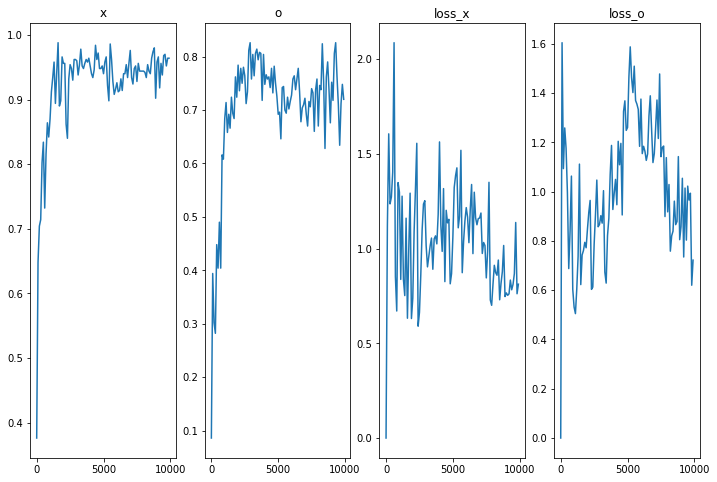

In [30]:
print(len(eval_data['x']), len(eval_data['o']))
plot_eval_data(eval_data, num_episodes=num_episodes, eval_each=eval_each)

### Доска 4x4

In [31]:
ROWS, COLS, WIN = 4, 4, 4
lr = 1e-5
w_decay = 1e-9

conv_out_size = 512
hidden_size = 512
mem_capacity = 10000

num_episodes = 10000
eval_each = 100
eval_num_games = 500

model_x, model_0, eval_data = dqn_learning(model_name='DQN',
                                           rows=ROWS, cols=COLS, win=WIN,
                                           lr=lr, w_decay=w_decay,
                                           conv_out_size=conv_out_size,
                                           hidden_size=hidden_size,
                                           criterion=LOSS,
                                           num_episodes=num_episodes, mem_capacity=mem_capacity,
                                           eval_each=eval_each, eval_num_games=eval_num_games)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:40<00:00, 24.98it/s]


100 100


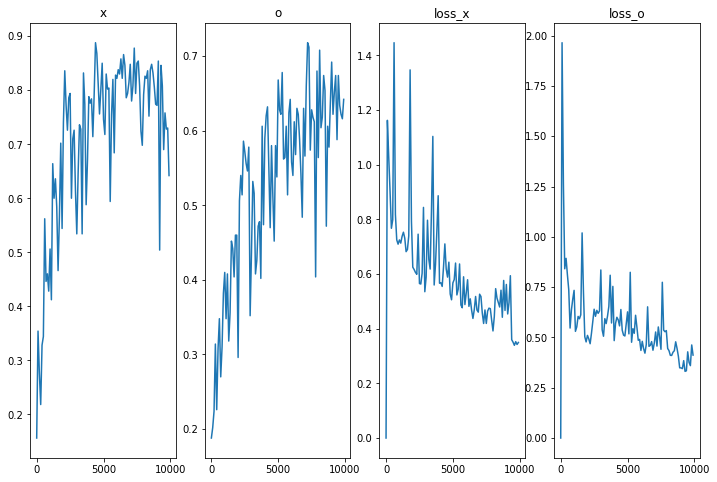

In [32]:
print(len(eval_data['x']), len(eval_data['o']))
plot_eval_data(eval_data, num_episodes=num_episodes, eval_each=eval_each)

### Dueling DQN

In [33]:
ROWS, COLS, WIN = 3, 3, 3
lr = 1e-5
w_decay = 1e-9

conv_out_size = 512
hidden_size = 512
mem_capacity = 10000

num_episodes = 10000
eval_each = 100
eval_num_games = 500

model_x, model_0, eval_data = dqn_learning(model_name='DuelingDQN',
                                           rows=ROWS, cols=COLS, win=WIN,
                                           lr=lr, w_decay=w_decay,
                                           conv_out_size=conv_out_size,
                                           hidden_size=hidden_size,
                                           criterion=LOSS,
                                           num_episodes=num_episodes, mem_capacity=mem_capacity,
                                           eval_each=eval_each, eval_num_games=eval_num_games)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:42<00:00, 35.37it/s]


100 100


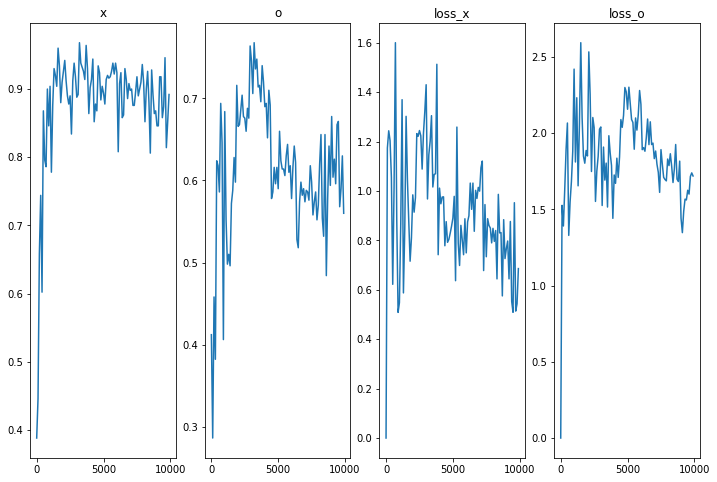

In [34]:
print(len(eval_data['x']), len(eval_data['o']))
plot_eval_data(eval_data, num_episodes=num_episodes, eval_each=eval_each)

## Часть третья: расширим и углубим поиск
Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.  
$\;\;\;\;$5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).  
$\;\;\;\;$6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [35]:
# not implemented yet

## Часть четвёртая, опциональная: AlphaZero
В опциональной части домашнего задания давайте попробуем всё-таки собрать всё вместе и завести настоящий AlphaZero. Если получится и будет обобщаться на большие доски, будет очень круто и будет стоить много дополнительных баллов.  
$\;\;\;\;$7. Реализуйте AlphaZero для крестиков-ноликов, используя MCTS из третьей части и DQN-сеть из второй части. Обучите стратегии для игры на больших досках (10х10 и выше, до пяти в ряд; опять же, может потребовать много времени, так что достаточно показать, что обучение началось и идёт).

In [36]:
# not implemented yet